# Differentiation with PyTorch

__Objective:__ learn how to compute gradients with PyTorch.

In [36]:
import sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../modules/')

from utilities import generate_linear_dataset

sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Create a fake dataset.

In [42]:
x_min, x_max = -1.5, 4.6
m_real = 3.
q_real = -0.5
sigma=1.3

n_samples_tot = 150
n_samples_val = 30

x_train, y_train, x_val, y_val = generate_linear_dataset(
    n_samples_tot,
    n_samples_val,
    x_min,
    x_max,
    m_real,
    q_real,
    sigma
)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([120, 1]),
 torch.Size([120]),
 torch.Size([30, 1]),
 torch.Size([30]))

Text(0, 0.5, 'y')

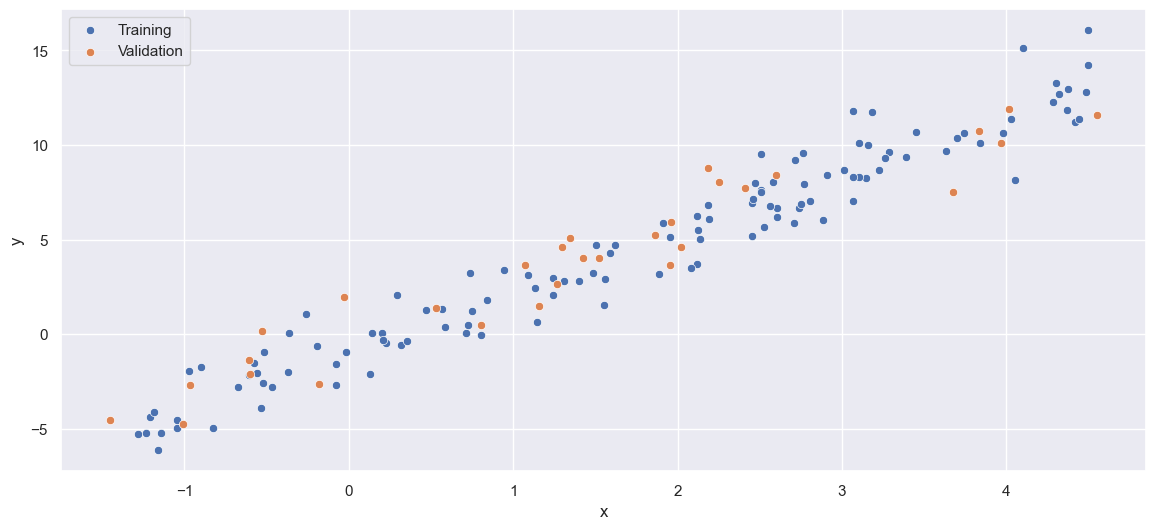

In [43]:
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train,
    label='Training'
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val,
    label='Validation'
)

plt.xlabel('x')
plt.ylabel('y')

Define a simple linear model and a loss function.

In [44]:
def model(x, w, b):
    """
    A simple linear model.
    """
    return w * x[:, 0] + b


def loss_fn(y_pred, y_true):
    """
    MSE
    """
    squared_errors = (y_true - y_pred) ** 2

    return squared_errors.mean()

Define initial values for the parameters to optimize with gradient descent.

In [45]:
params = torch.tensor(
    [1., 0.],
    # Indicate to PyTorch to keep track of
    # every operation performed with this
    # tensor.
    requires_grad=True
)

# Initially the `grad` attribute of the tensor
# is null.
params.grad is None

True

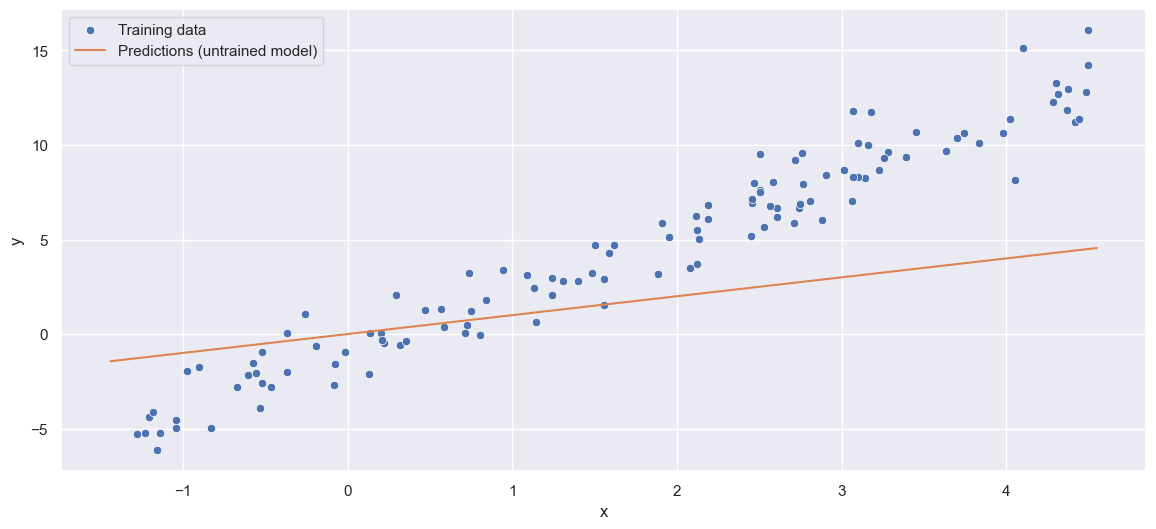

In [46]:
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train,
    label='Training data',
    color=sns.color_palette()[0]
)

x_pred = torch.linspace(x.min(), x.max(), 100)[:, None]

# Note: we need to `detach` the tensor (disconnect it from the
# computation graph for the gradient) to convert it to a
# NumPy array.
y_pred = model(x_pred, *params).detach()

sns.lineplot(
    x=x_pred[:, 0],
    y=y_pred,
    label='Predictions (untrained model)',
    color=sns.color_palette()[1]
)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

Compute the loss and its gradient w.r.t. the parameters.

In [47]:
loss = loss_fn(model(x_train, *params), y_train)

# Compute gradient w.r.t. the parameters.
loss.backward()

# The `grad` attribute of the tensor w.r.t.
# which we differentiated is now populated.
params.grad

tensor([-21.1410,  -5.3577])

**WARNING: the values of the gradient are ACCUMULATED in the `grad` attribute**

If we call `backward` multiple times to compute the gradient of the loss, we get different values for the `grad` attribute of the tensors w.r.t. which we differentiated.

In [48]:
for i in range(10):
    loss = loss_fn(model(x, *params), y)
    loss.backward()

    print(f'Iteration: {i+1} | Gradient: {params.grad}')

Iteration: 1 | Gradient: tensor([-39.9160, -10.1148])
Iteration: 2 | Gradient: tensor([-58.6910, -14.8718])
Iteration: 3 | Gradient: tensor([-77.4660, -19.6289])
Iteration: 4 | Gradient: tensor([-96.2409, -24.3859])
Iteration: 5 | Gradient: tensor([-115.0159,  -29.1430])
Iteration: 6 | Gradient: tensor([-133.7909,  -33.9000])
Iteration: 7 | Gradient: tensor([-152.5659,  -38.6571])
Iteration: 8 | Gradient: tensor([-171.3409,  -43.4141])
Iteration: 9 | Gradient: tensor([-190.1158,  -48.1712])
Iteration: 10 | Gradient: tensor([-208.8908,  -52.9282])


If we want to compute the actual gradient at each iteration, then we need to reset the `grad` attribute to zero explicitly at each step.

In [49]:
for i in range(10):
    # Resetting the gradient to zero prevents the
    # values from accumulating in the attribute.
    params.grad.zero_()

    loss = loss_fn(model(x_train, *params), y_train)
    loss.backward()

    print(f'Iteration: {i+1} | Gradient: {params.grad}')

Iteration: 1 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 2 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 3 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 4 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 5 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 6 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 7 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 8 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 9 | Gradient: tensor([-21.1410,  -5.3577])
Iteration: 10 | Gradient: tensor([-21.1410,  -5.3577])


Training loop.

In [50]:
def training_step(training_data, val_data, model, params, loss_fn, learning_rate):
    x_train, y_train = training_data
    x_val, y_val = val_data
    
    # Compute training loss.
    y_pred = model(x_train, *params)
    loss = loss_fn(y_pred, y_train)

    # Compute validation loss.
    with torch.no_grad():
        y_pred_val = model(x_val, *params)
        val_loss = loss_fn(y_pred_val, y_val)

    # Reset the value of the gradient.
    if params.grad is not None:
        params.grad.zero_()
    
    # Compute gradient.
    loss.backward()

    # Perform a gradient descent step.
    with torch.no_grad():
        params -= learning_rate * params.grad

    return float(loss.detach().numpy()), float(val_loss.detach().numpy())

In [51]:
# Re-initialize the parameters.
params = torch.tensor(
    [1., 0.],
    requires_grad=True
)

In [52]:
# Training hyperparameters.
learning_rate = 1e-2
n_epochs = 500

training_history = {
    'loss': [],
    'val_loss': []
}

# Training loop.
for i in range(n_epochs):
    loss, val_loss = training_step(
        (x_train, y_train),
        (x_val, y_val),
        model,
        params,
        loss_fn,
        learning_rate
    )

    training_history['loss'].append(loss)
    training_history['val_loss'].append(val_loss)
    
print(params)

tensor([ 3.0943, -0.8855], requires_grad=True)


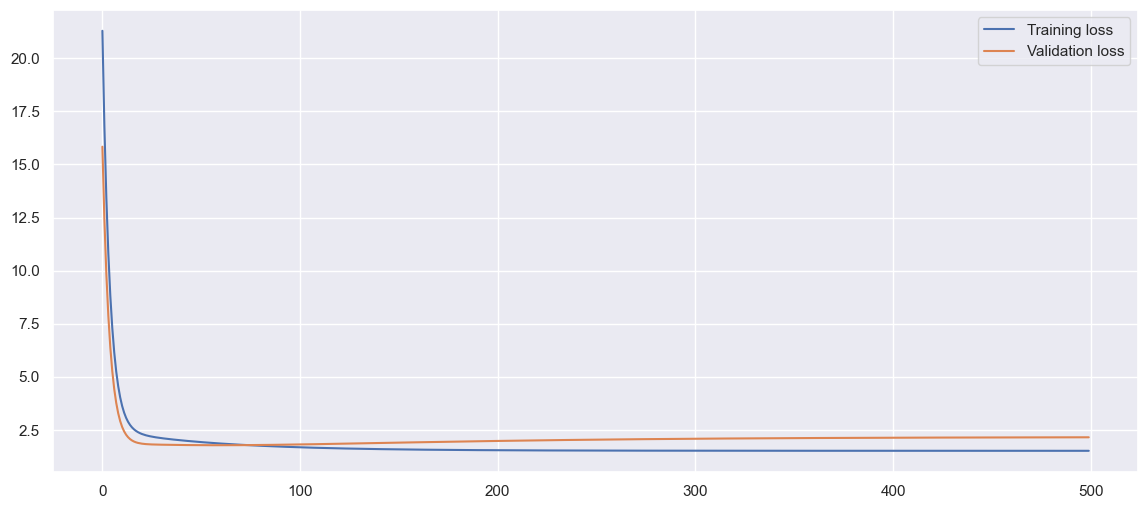

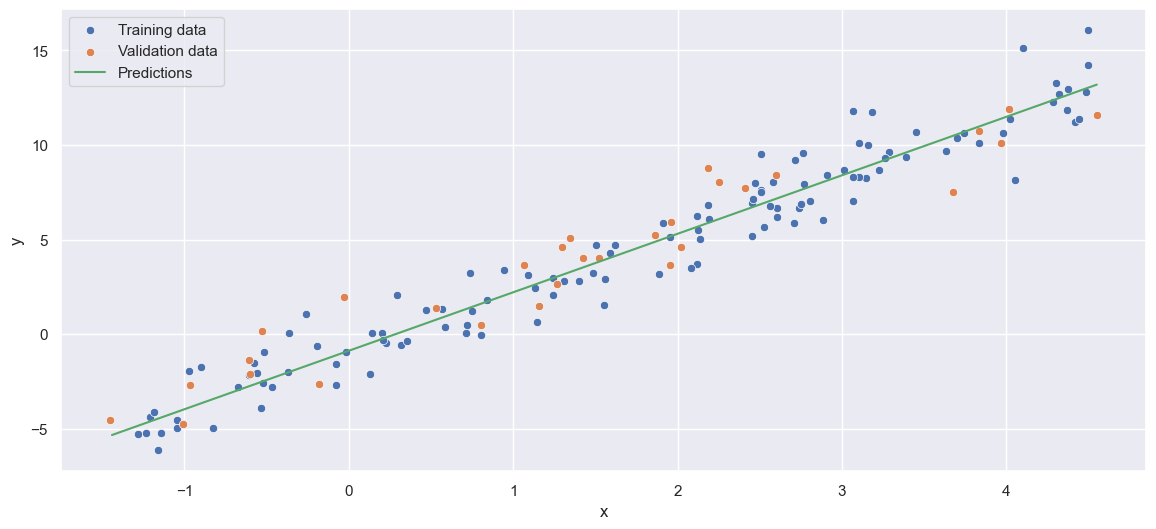

In [53]:
# Training history.
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=torch.arange(len(training_history['loss'])).numpy(),
    y=training_history['loss'],
    label='Training loss',
)

sns.lineplot(
    x=torch.arange(len(training_history['val_loss'])).numpy(),
    y=training_history['val_loss'],
    label='Validation loss',
)


# Data and predictions.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train,
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val,
    label='Validation data',
    color=sns.color_palette()[1]
)

x_pred = torch.linspace(x.min(), x.max(), 100)[:, None]

# Note: we need to `detach` the tensor (disconnect it from the
# computation graph for the gradient) to convert it to a
# NumPy array.
y_pred = torch.flatten(model(x_pred, *params).detach())

sns.lineplot(
    x=x_pred[:, 0],
    y=y_pred,
    label='Predictions',
    color=sns.color_palette()[2]
)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

Train the model using an optimizer.

In [63]:
from torch.optim import SGD
from utilities import training_step_optimizer

In [65]:
# Re-initialize the parameters.
params = torch.tensor(
    [1., 0.],
    requires_grad=True
)

training_history_optimizer = {
    'loss': [],
    'val_loss': []
}

# Training hyperparameters.
learning_rate = 1e-2
n_epochs = 500

optimizer = SGD([params], lr=learning_rate)

for i in range(n_epochs):
    loss, val_loss = training_step_optimizer(
        (x_train, y_train),
        (x_val, y_val),
        model,
        loss_fn,
        optimizer,
        params=params
    )

    training_history_optimizer['loss'].append(loss)
    training_history_optimizer['val_loss'].append(val_loss)

params

tensor([ 3.0943, -0.8855], requires_grad=True)

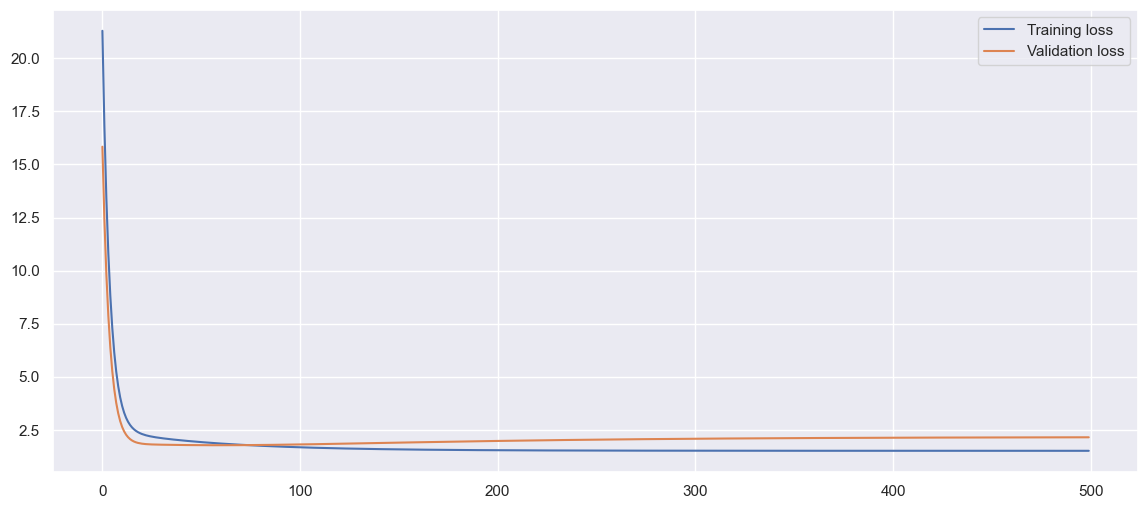

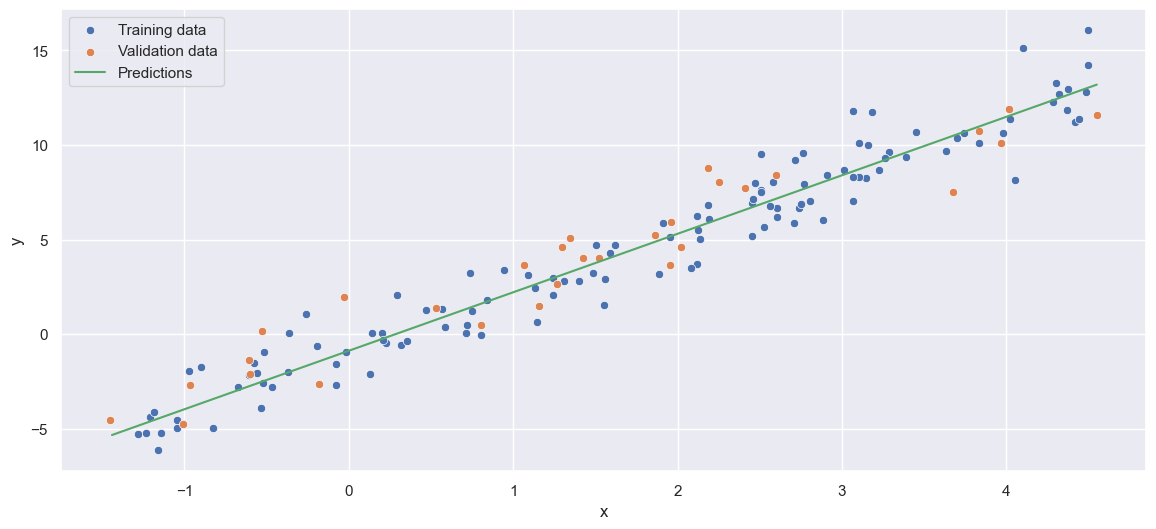

In [66]:
# Training history.
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=torch.arange(len(training_history_optimizer['loss'])).numpy(),
    y=training_history['loss'],
    label='Training loss',
)

sns.lineplot(
    x=torch.arange(len(training_history_optimizer['val_loss'])).numpy(),
    y=training_history['val_loss'],
    label='Validation loss',
)


# Data and predictions.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train,
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val,
    label='Validation data',
    color=sns.color_palette()[1]
)

x_pred = torch.linspace(x.min(), x.max(), 100)[:, None]

# Note: we need to `detach` the tensor (disconnect it from the
# computation graph for the gradient) to convert it to a
# NumPy array.
y_pred = torch.flatten(model(x_pred, *params).detach())

sns.lineplot(
    x=x_pred[:, 0],
    y=y_pred,
    label='Predictions',
    color=sns.color_palette()[2]
)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()